In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


## Generating the Data

In [162]:
def randomData(samples_per_class = 1000, noise_features = 0):
    class1 = np.random.multivariate_normal(mean = [1.5,1.5], cov = np.identity(2), size = samples_per_class)
    class2 = np.random.multivariate_normal(mean = [-1.5,1.5], cov = np.identity(2), size = samples_per_class)
    class3 = np.random.multivariate_normal(mean = [0,(1-np.sqrt(3))*1.5], cov = np.identity(2), size = samples_per_class) 
    
    if noise_features > 0:
        noiseX = np.random.uniform(low = -1, high = 1, size = [3*samples_per_class, noise_features])
        X = np.concatenate([class1, class2, class3], axis = 0)
        X = np.concatenate([X, noiseX], axis = 1)
    else:
        X = np.concatenate([class1, class2, class3], axis = 0)
    
    y = [0] * samples_per_class + [1] * samples_per_class + [2] * samples_per_class

    return X, y

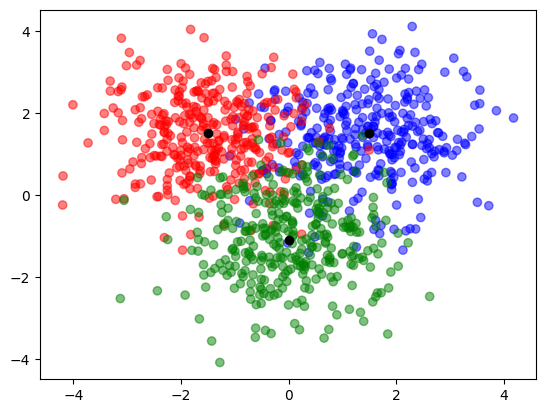

In [172]:
colors = {0: "blue", 1: "red", 2: "green" }
x, y = randomData(samples_per_class = 333)

x_center = [1.5, -1.5, 0]
y_center = [1.5, 1.5, 1.5*(1-np.sqrt(3))]

plt.scatter(x=x[:,0], y=x[:,1], c=[colors[label] for label in y], alpha=0.5)
plt.scatter(x=x_center, y=y_center, c= "black")
plt.show()

## Adding Noise with 1NN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, weights = "distance", n_jobs=-1)
scaler = StandardScaler()

In [277]:
random_dimensions = np.logspace(start = 1, stop = 4, dtype = int)
accuracies = []

for dim in tqdm(random_dimensions):
    X_test, y_test = randomData(samples_per_class=333, noise_features=dim)
    X_train, y_train = randomData(samples_per_class=333, noise_features=dim)
    
    X_scaled = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    accuracy = 0
    for _ in range(45):        
        knn.fit(X_train,y_train)
        predictions= knn.predict(X_test)
        accuracy += accuracy_score(predictions,y_test)
    accuracies.append(accuracy/25)

100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


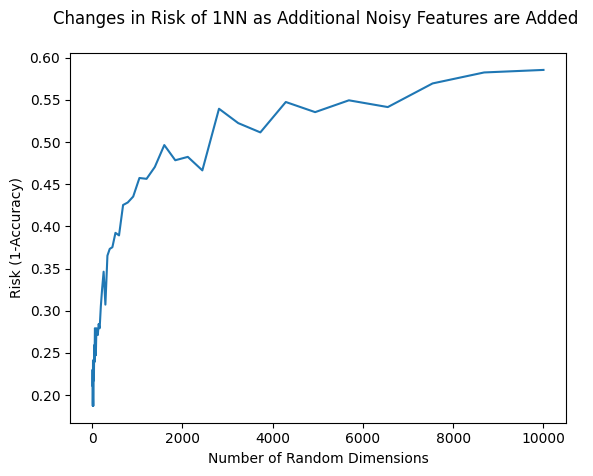

In [189]:
plt.plot(random_dimensions,[1-i for i in accuracies])
plt.title("Changes in Risk of 1NN as Additional Noisy Features are Added \n")
plt.xlabel("Number of Random Dimensions")
plt.ylabel("Risk (1-Accuracy)")
#plt.ylim(0.1,0.7)
plt.show()

## Can we remedy this with sample size?

In [166]:
sample_sizes = np.logspace(start = np.log10(300), stop = np.log10(10000), dtype = int)
samples_accuracies = []

for samples in tqdm(sample_sizes):
    X_test, y_test = randomData(samples_per_class=samples, noise_features = 4000)
    X_train, y_train = randomData(samples_per_class=333, noise_features = 4000)
    accuracy = 0
    for _ in range(25):        
        knn.fit(X_train,y_train)
        predictions= knn.predict(X_test)
        accuracy += accuracy_score(predictions,y_test)
    samples_accuracies.append(accuracy/25)

100%|██████████| 50/50 [07:25<00:00,  8.92s/it]


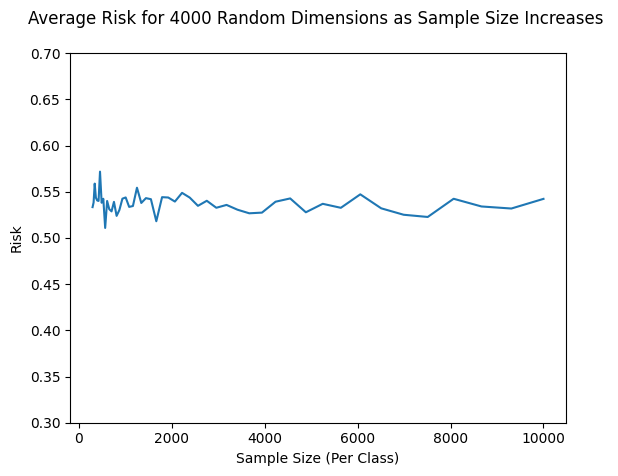

In [193]:
plt.plot(sample_sizes,[1-i for i in samples_accuracies])
plt.title("Average Risk for 4000 Random Dimensions as Sample Size Increases \n")
plt.ylabel("Risk")
plt.xlabel("Sample Size (Per Class)")
plt.ylim(0.3, 0.7)
plt.show()

## Dimensionality Reduction with PCA

In [195]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [226]:
scale = StandardScaler()

In [257]:
n = 10
x, y = randomData(noise_features=n)
x = scale.fit_transform(x)

pca = PCA(n_components=n+2)
pca.fit(x)
transformed_x = pca.transform(x)

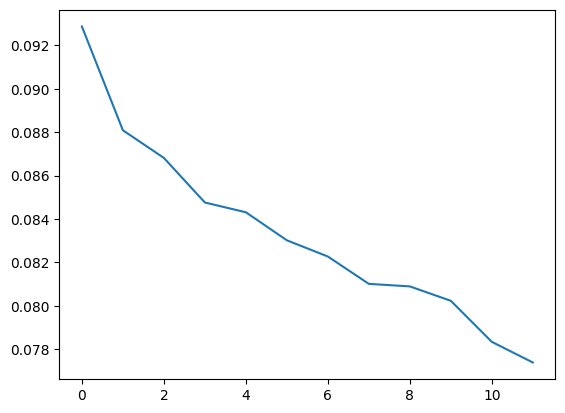

In [258]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

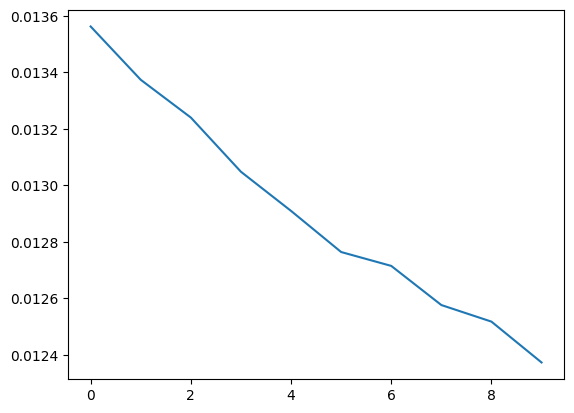

In [222]:
plt.plot(pca.explained_variance_ratio_[:10])

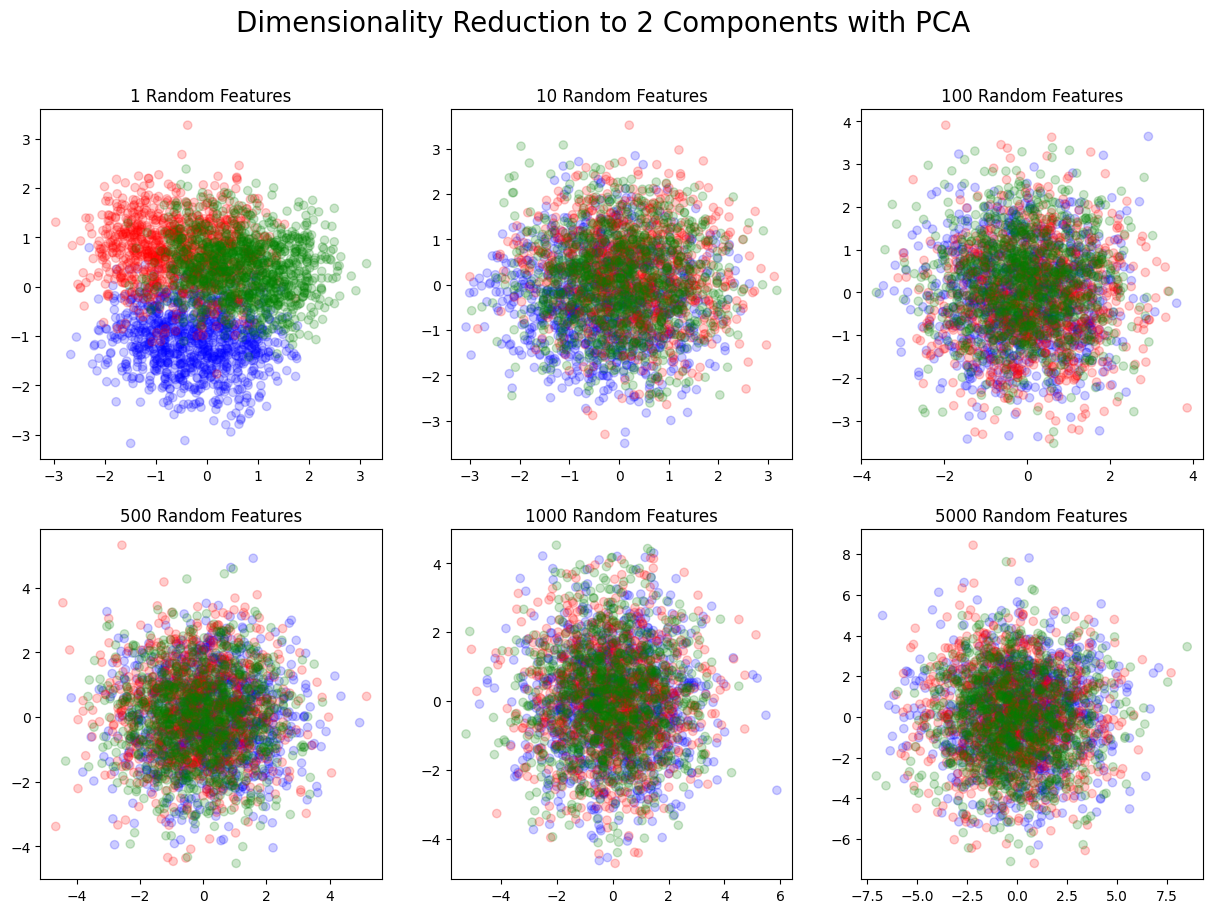

In [292]:
ns = [1, 10, 100, 500, 1000, 5000]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i,n in enumerate(ns):
    x, y = randomData(noise_features=n)
    x = scale.fit_transform(x)

    pca = PCA(n_components=2)
    pca.fit(x)
    transformed_x = pca.transform(x)
    scatter = axs[i//3, i % 3].scatter(x=transformed_x[:,0], y= transformed_x[:,1], c = [colors[label] for label in y], alpha=0.2,
                                       label = f"{n} Random Features")
    axs[i//3, i % 3].set_title(f"{n} Random Features")
plt.suptitle("Dimensionality Reduction to 2 Components with PCA", size = 20)
plt.show()

In [308]:
random_dimensions = np.logspace(start = 1, stop = 4, dtype = int)
pca_accuracies = []

for dim in tqdm(random_dimensions):
    X_test, y_test = randomData(samples_per_class=333, noise_features=dim)
    X_train, y_train = randomData(samples_per_class=333, noise_features=dim)
    
    X_scaled = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    accuracy = 0
    for _ in range(45):        
        knn.fit(X_train,y_train)
        predictions= knn.predict(X_test)
        accuracy += accuracy_score(predictions,y_test)
    pca_accuracies.append(accuracy/45)
    

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


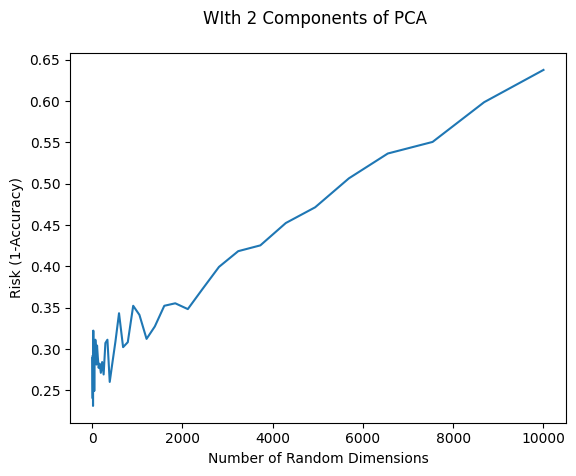

In [309]:
plt.plot(random_dimensions,[1-i for i in pca_accuracies])
plt.title("WIth 2 Components of PCA \n")
plt.xlabel("Number of Random Dimensions")
plt.ylabel("Risk (1-Accuracy)")
#plt.ylim(0.1,0.7)
plt.show()

## Trying with T-SNE

In [299]:
from sklearn.manifold import TSNE

In [300]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(x)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)  # Reduce to 2 dimensions
data_tsne = tsne.fit_transform(data_scaled)

print("Data shape after t-SNE:", data_tsne.shape)

Data shape after t-SNE: (3000, 2)


6it [00:42,  7.01s/it]


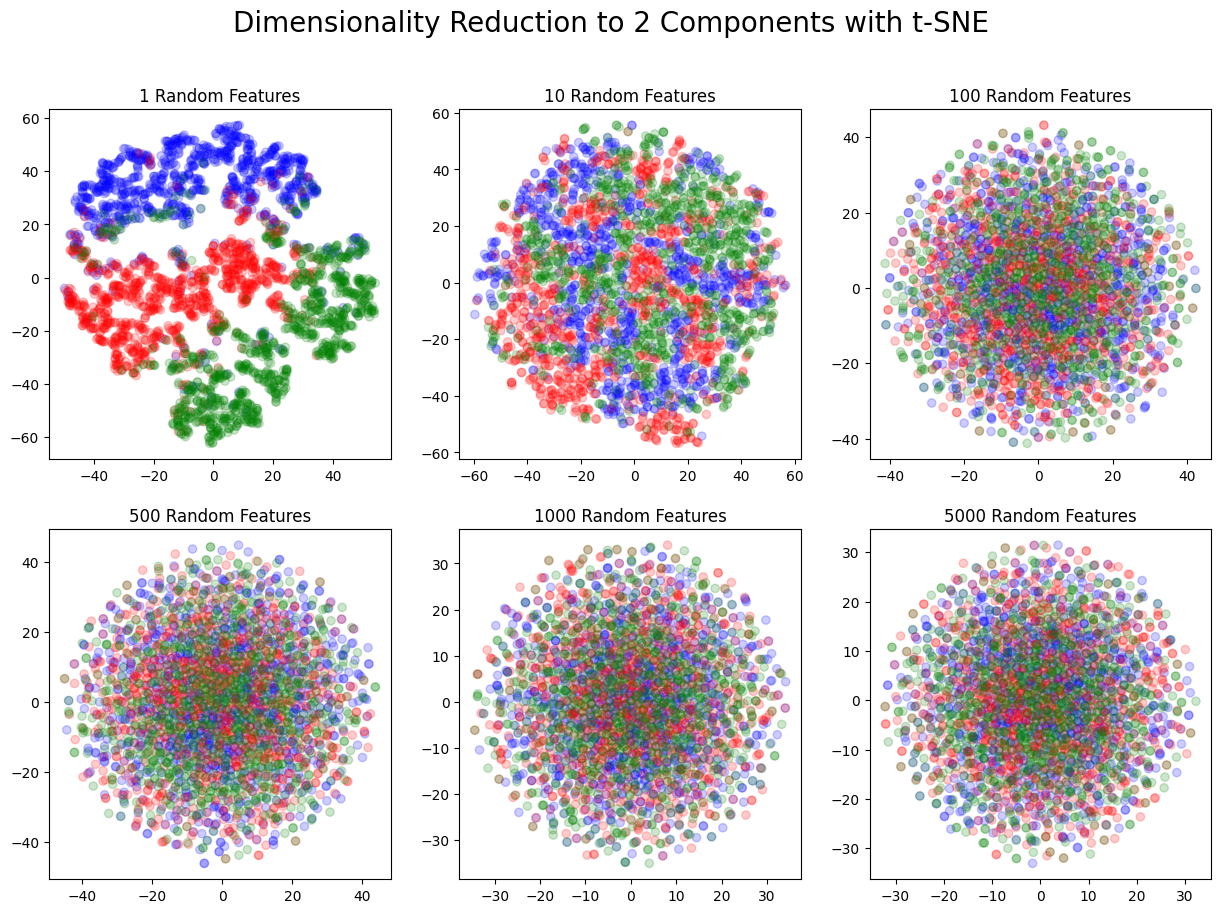

In [302]:
ns = [1, 10, 100, 500, 1000, 5000]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i,n in tqdm(enumerate(ns)):
    x, y = randomData(noise_features=n)
    x = scale.fit_transform(x)

    transformed_x = tsne.fit_transform(x)
    scatter = axs[i//3, i % 3].scatter(x=transformed_x[:,0], y= transformed_x[:,1], c = [colors[label] for label in y], alpha=0.2,
                                       label = f"{n} Random Features")
    axs[i//3, i % 3].set_title(f"{n} Random Features")
plt.suptitle("Dimensionality Reduction to 2 Components with t-SNE", size = 20)
plt.show()

In [334]:
random_dimensions = np.logspace(start = 1, stop = 4, dtype = int)
tsne_accuracies = []

for dim in tqdm(random_dimensions):
    X_test, y_test = randomData(samples_per_class=333, noise_features=dim)
    X_train, y_train = randomData(samples_per_class=333, noise_features=dim)
    
    X_scaled = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X = tsne.fit_transform(np.vstack([X_train,X_test]))
    X_train = X[:len(X_train)]
    X_test = X[len(X_train):]
    
    accuracy = 0
    for _ in range(45):        
        knn.fit(X_train,y_train)
        predictions= knn.predict(X_test)
        accuracy += accuracy_score(predictions,y_test)
    tsne_accuracies.append(accuracy/45)

100%|██████████| 50/50 [04:21<00:00,  5.24s/it]


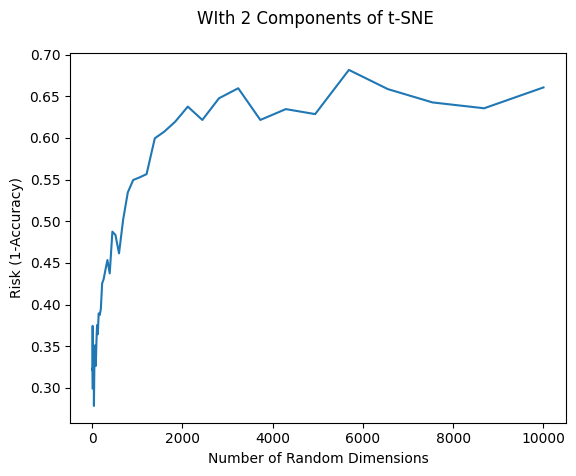

In [306]:
plt.plot(random_dimensions,[1-i for i in tsne_accuracies])
plt.title("WIth 2 Components of t-SNE \n")
plt.xlabel("Number of Random Dimensions")
plt.ylabel("Risk (1-Accuracy)")
#plt.ylim(0.1,0.7)
plt.show()

## Plot them together

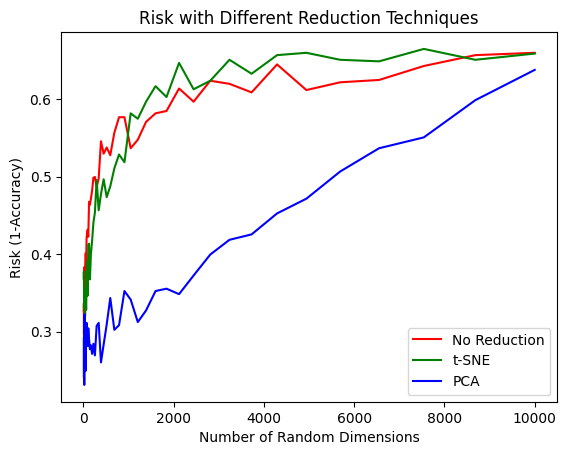

In [335]:
plt.plot(random_dimensions,[1-i for i in accuracies], c = "red", label="No Reduction")
plt.plot(random_dimensions,[1-i for i in tsne_accuracies], c = "green", label="t-SNE")
plt.plot(random_dimensions,[1-i for i in pca_accuracies], c = "blue", label="PCA")
plt.title("Risk with Different Reduction Techniques")
plt.xlabel("Number of Random Dimensions")
plt.ylabel("Risk (1-Accuracy)")
plt.legend()
#plt.ylim(0.1,0.7)
plt.show()